<h1><center>IMT2118 - Ciencia de Datos Geoespaciales (2024-1) </center></h1>
<h2><center>Proyecto:   </center></h2>

### Imports

In [125]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap, ee
from shapely.geometry import LineString, Point
import matplotlib.patches as mpatches

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

### Lectura de Datos

In [126]:
stgo = gpd.read_file("Datos/santiago_urbano.gpkg")
roi_shapely = stgo.union_all()

In [127]:
Areas_Verdes = gpd.read_file("Datos/Areas_Verdes.gpkg")
Bomberos = gpd.read_file("Datos/Bomberos.gpkg")
Censo_2017 = gpd.read_file("Datos/Censo_2017.gpkg")
Comercio = gpd.read_file("Datos/Comercio.gpkg")
Ejes = gpd.read_file("Datos/Ejes.gpkg")
EstablecimientosSalud = gpd.read_file("Datos/EstablecimientosSalud.gpkg")
Limite_Comunal = gpd.read_file("Datos/Limite_Comunal.gpkg")
Manzanas = gpd.read_file("Datos/Manzanas.gpkg")
Paraderos = gpd.read_file("Datos/Paraderos.gpkg")


In [128]:
Areas_Verdes = Areas_Verdes[Areas_Verdes.geometry.within(roi_shapely)]
Bomberos = Bomberos[Bomberos.geometry.within(roi_shapely)]
Censo_2017 = Censo_2017[Censo_2017.geometry.within(roi_shapely)]
Comercio = Comercio[Comercio.geometry.within(roi_shapely)]
Ejes = Ejes[Ejes.geometry.within(roi_shapely)]
EstablecimientosSalud = EstablecimientosSalud[EstablecimientosSalud.geometry.within(roi_shapely)]
Manzanas = Manzanas[Manzanas.geometry.within(roi_shapely)]
Paraderos = Paraderos[Paraderos.geometry.within(roi_shapely)]

### Comunas

Filtramos que el Limite comunal solo incluya nuestra zona de interes

In [129]:
Limite_Comunal['geometry'] = Limite_Comunal.geometry.intersection(roi_shapely)
Limite_Comunal = Limite_Comunal[~Limite_Comunal.is_empty]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Santiago urbano
stgo.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='Santiago Urbano')

# Límite comunal
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1.5, label='Límite Comunal')

ax.set_title('Santiago Urbano vs Límite Comunal', fontsize=16)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

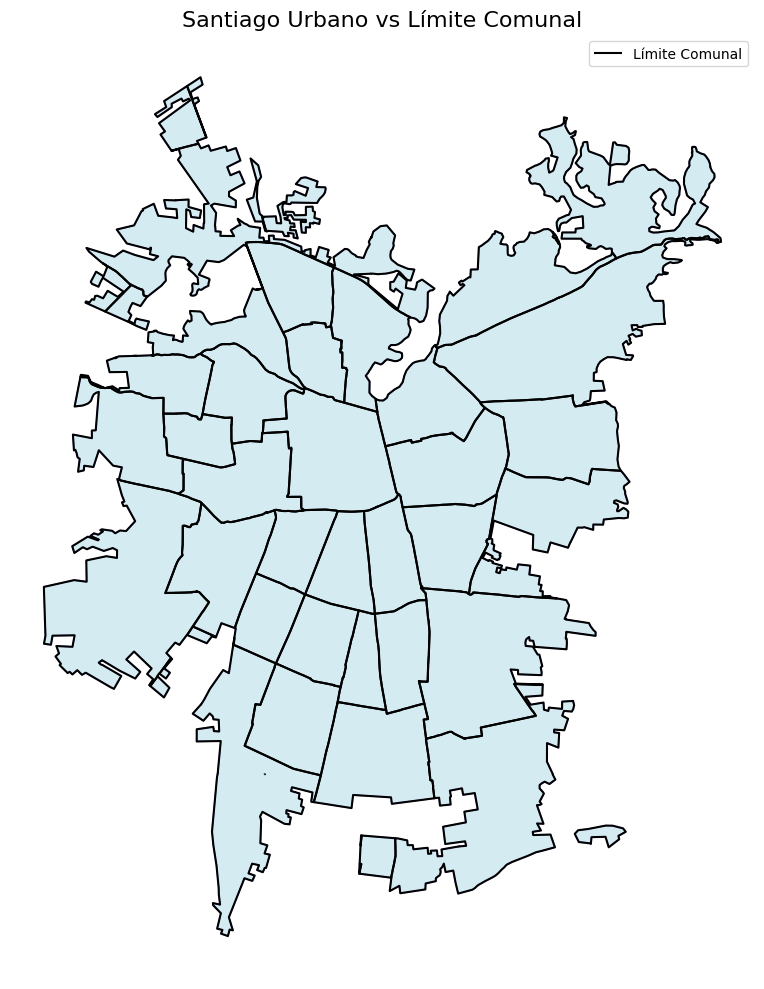

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))

# Santiago urbano
stgo.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='Santiago Urbano')

# Límite comunal
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1.5, label='Límite Comunal')

ax.set_title('Santiago Urbano vs Límite Comunal', fontsize=16)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

## Metro

In [131]:
df = pd.read_csv("Datos/plantilla_metro.csv", decimal=',')
for col in ['Lat Origen', 'Long Origen', 'Lat Destino', 'Long Destino']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

df['geometry'] = df.apply(
    lambda row: LineString([
        (row['Long Origen'], row['Lat Origen']),
        (row['Long Destino'], row['Lat Destino'])
    ]),
    axis=1
)

Metro = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
Metro['linea'] = Metro['linea'].astype(str)

colores_lineas = {
    '1': 'E1251B',
    '2': 'FFD600',
    '3': '682600',
    '4': '0072BC',
    '4A': '5FAEE2',
    '5': '365A05',
    '6': 'B303DF'
}
Metro['color'] = Metro['linea'].map(colores_lineas)

features = []
for _, row in Metro.iterrows():
    geom = geemap.geopandas_to_ee(gpd.GeoDataFrame([row], crs="EPSG:4326")).geometry()
    feature = ee.Feature(geom).set('style', {
        'color': row['color'],
        'width': 4,
        'lineType': 'solid'
    })
    features.append(feature)

fc = ee.FeatureCollection(features)

m_metro = geemap.Map(center=[-33.45, -70.65], zoom=12)
m_metro.add_gdf(Limite_Comunal, "Comunas Santiago Urbano", style={'color': 'black', 'fillOpacity': 0.2, 'weight': 1.5})
m_metro.addLayer(fc.style(**{'styleProperty': 'style'}), {}, 'Lineas de Metro')
m_metro



Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [132]:
estaciones = pd.concat([
    Metro[['Estación Origen', 'Lat Origen', 'Long Origen']].rename(
        columns={'Estación Origen': 'Estacion', 'Lat Origen': 'Lat', 'Long Origen': 'Lon'}),
    Metro[['Estación Destino', 'Lat Destino', 'Long Destino']].rename(
        columns={'Estación Destino': 'Estacion', 'Lat Destino': 'Lat', 'Long Destino': 'Lon'})
], ignore_index=True).drop_duplicates(subset=['Estacion'])

estaciones['geometry'] = estaciones.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
gdf_estaciones = gpd.GeoDataFrame(estaciones, geometry='geometry', crs="EPSG:4326")

gdf_estaciones_comunas = gpd.sjoin(gdf_estaciones, Limite_Comunal, how='left', predicate='within')

conteo = gdf_estaciones_comunas['comuna'].value_counts().sort_index()

comunas_todas = Limite_Comunal['comuna'].unique()

comunas_sin_metro = set(comunas_todas) - set(conteo.index)

#print("Estaciones de metro por comuna:")
#print(conteo)
print("Comunas sin estaciones de metro:")
print(sorted(comunas_sin_metro))


Comunas sin estaciones de metro:
['CERRO NAVIA', 'COLINA', 'HUECHURABA', 'LA PINTANA', 'LAMPA', 'LO BARNECHEA', 'LO ESPEJO', 'RENCA', 'VITACURA']


In [133]:
# Crear personas_por_comuna agrupando por nombre de comuna
personas_por_comuna = Manzanas.groupby('DES_COMU')['PERSONAS'].sum()

# Filtrar las comunas sin metro en personas_por_comuna
personas_sin_metro = personas_por_comuna[personas_por_comuna.index.isin(comunas_sin_metro)]
print(personas_sin_metro)
print(f"Total de personas en comunas sin metro: {personas_sin_metro.sum()}")

DES_COMU
CERRO NAVIA     120684
HUECHURABA       51721
LA PINTANA      174065
LAMPA                4
LO BARNECHEA     60448
LO ESPEJO        98651
RENCA           110913
VITACURA         76696
Name: PERSONAS, dtype: int64
Total de personas en comunas sin metro: 693182


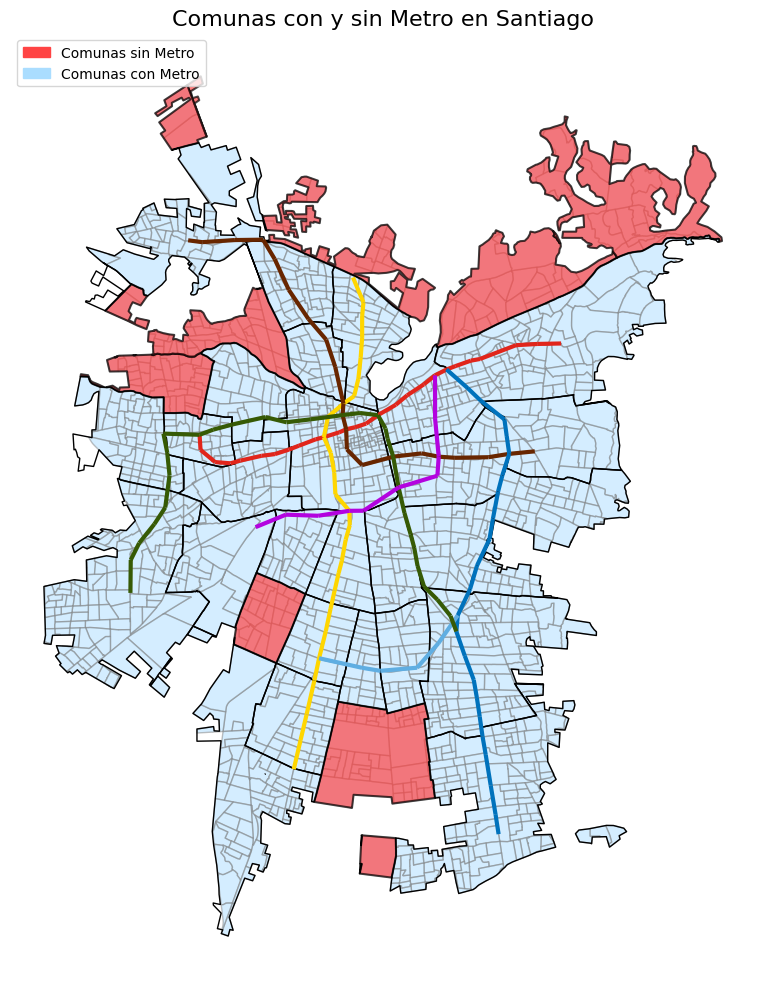

In [134]:
zonas = gpd.read_file("Datos/datosZonas_Stgo_C2017.gpkg")
zonas = zonas.to_crs(Limite_Comunal.crs)


Limite_Comunal['sin_metro'] = Limite_Comunal['comuna'].str.upper().isin(comunas_sin_metro)

fig, ax = plt.subplots(figsize=(10, 10))

# Zonas censales
zonas.plot(ax=ax, color='#aaddff', edgecolor='gray', alpha=0.5, label='Zonas Censo 2017')

# Comunas sin metro
Limite_Comunal[Limite_Comunal['sin_metro']].plot(
    ax=ax, color='#ff4444', edgecolor='black', linewidth=1.5, alpha=0.7, label='Comunas sin Metro'
)

# Comunas con metro
Limite_Comunal[~Limite_Comunal['sin_metro']].plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=1, label='Comunas con Metro'
)

# Líneas de metro
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax, color=f'#{color}', linewidth=3, label=f'Línea {linea}'
    )

# Leyenda manual
leyenda = [
    mpatches.Patch(color='#ff4444', label='Comunas sin Metro'),
    mpatches.Patch(color='#aaddff', label='Comunas con Metro')
]

ax.legend(handles=leyenda, loc='upper left', fontsize=10)
ax.set_title('Comunas con y sin Metro en Santiago', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


## Densidad Poblacional

In [135]:
Limite_Comunal

gid  region   provincia               comuna id_com               nombre  \
2   269    13.0    SANTIAGO           LA PINTANA  13112           La Pintana   
4   271    13.0    SANTIAGO            EL BOSQUE  13105            El Bosque   
5   272    13.0  CORDILLERA          PUENTE ALTO  13201          Puente Alto   
6   273    13.0       MAIPO         SAN BERNARDO  13401         San Bernardo   
7   275    13.0    SANTIAGO            LA GRANJA  13111            La Granja   
9   277    13.0    SANTIAGO          LA CISTERNA  13109          La Cisterna   
10  278    13.0    SANTIAGO            LO ESPEJO  13116            Lo Espejo   
11  279    13.0    SANTIAGO           LA FLORIDA  13110           La Florida   
12  280    13.0    SANTIAGO           SAN MIGUEL  13130           San Miguel   
13  281    13.0    SANTIAGO  PEDRO AGUIRRE CERDA  13121  Pedro Aguirre Cerda   
14  282    13.0    SANTIAGO            CERRILLOS  13102            Cerrillos   
15  284    13.0    SANTIAGO                MACUL  13118                Macul   
16  288    13.0    SANTIAGO             LO PRADO  13117             Lo Prado   
17  290    13.0    SANTIAGO             LA REINA  13113             La Reina   
18  291    13.0    SANTIAGO             SANTIAGO  13101             Santiago   
19  293    13.0    SANTIAGO          CERRO NAVIA  13103          Cerro Navia   
20  294    13.0    SANTIAGO        QUINTA NORMAL  13126        Quinta Normal   
21  295    13.0    SANTIAGO          PROVIDENCIA  13123          Providencia   
22  296    13.0    SANTIAGO        INDEPENDENCIA  13108        Independencia   
23  297    13.0    SANTIAGO                RENCA  13128                Renca   
24  298    13.0    SANTIAGO             RECOLETA  13127             Recoleta   
25  300    13.0    SANTIAGO           LAS CONDES  13114           Las Condes   
26  301    13.0    SANTIAGO             VITACURA  13132             Vitacura   
27  302    13.0    SANTIAGO           HUECHURABA  13107           Huechuraba   
28  304    13.0    SANTIAGO         LO BARNECHEA  13115         Lo Barnechea   
29  305    13.0   CHACABUCO               COLINA  13301               Colina   
32  299    13.0    SANTIAGO             CONCHALI  13104             Conchalí   
34  287    13.0    SANTIAGO     ESTACION CENTRAL  13106     Estación Central   
36  285    13.0    SANTIAGO                MAIPU  13119                Maipú   
38  289    13.0    SANTIAGO                NUNOA  13120                Ñuñoa   
40  286    13.0    SANTIAGO            PENALOLEN  13122            Peñalolén   
41  283    13.0    SANTIAGO          SAN JOAQUIN  13129          San Joaquín   
42  274    13.0    SANTIAGO            SAN RAMON  13131            San Ramón   
47  343    13.0    SANTAIGO            QUILICURA  13125            Quilicura   
48  344    13.0   CHACABUCO                LAMPA  13302                Lampa   
49  345    13.0    SANTIAGO             PUDAHUEL  13124             Pudahuel   

                                             geometry  sin_metro  
2   MULTIPOLYGON (((-70.63104 -33.55841, -70.63091...       True  
4   POLYGON ((-70.65382 -33.54992, -70.65383 -33.5...      False  
5   MULTIPOLYGON (((-70.62852 -33.62685, -70.62844...      False  
6   MULTIPOLYGON (((-70.7062 -33.53148, -70.7059 -...      False  
7   POLYGON ((-70.61234 -33.5556, -70.61332 -33.55...      False  
9   POLYGON ((-70.64489 -33.51836, -70.64496 -33.5...      False  
10  POLYGON ((-70.67104 -33.51078, -70.6718 -33.51...       True  
11  POLYGON ((-70.55425 -33.54784, -70.55444 -33.5...      False  
12  POLYGON ((-70.63722 -33.51875, -70.63745 -33.5...      False  
13  POLYGON ((-70.65529 -33.47725, -70.65556 -33.4...      False  
14  MULTIPOLYGON (((-70.68613 -33.47642, -70.68606...      False  
15  POLYGON ((-70.57678 -33.47026, -70.5767 -33.47...      False  
16  POLYGON ((-70.72119 -33.43664, -70.71966 -33.4...      False  
17  POLYGON ((-70.52148 -33.45961, -70.52204 -33.4...      False  
18  POLYGON ((-70.65104 -33.43207, -70

In [136]:
zonas = zonas.sjoin(Limite_Comunal[['comuna', 'geometry']], how='left', predicate='intersects')


In [147]:
zonas

NZONA  EDAD_65YMA  INMIGRANTE  PERSONAS  HOMBRES  MUJERES  PUEBLO  \
0         0           4          11        78       39       16       7   
0         0           4          11        78       39       16       7   
0         0           4          11        78       39       16       7   
1         1           0           0        57       26       16       4   
1         1           0           0        57       26       16       4   
...     ...         ...         ...       ...      ...      ...     ...   
1614   1614         303        1199      3997     2065     1932     437   
1615   1615         107         221      1218      573      645      96   
1616   1616         202         210      2052      976     1076      40   
1616   1616         202         210      2052      976     1076      40   
1616   1616         202         210      2052      976     1076      40   

                                               geometry  index_right  \
0     POLYGON ((-70.72358 -33.32546, -70.72397 -33.3...           47   
0     POLYGON ((-70.72358 -33.32546, -70.72397 -33.3...           48   
0     POLYGON ((-70.72358 -33.32546, -70.72397 -33.3...           29   
1     POLYGON ((-70.72395 -33.31337, -70.72393 -33.3...           48   
1     POLYGON ((-70.72395 -33.31337, -70.72393 -33.3...           29   
...                                                 ...          ...   
1614  POLYGON ((-70.66477 -33.44733, -70.6648 -33.44...           18   
1615  POLYGON ((-70.66026 -33.44732, -70.66023 -33.4...           18   
1616  POLYGON ((-70.5275 -33.37744, -70.52764 -33.37...           25   
1616  POLYGON ((-70.5275 -33.37744, -70.52764 -33.37...           26   
1616  POLYGON ((-70.5275 -33.37744, -70.52764 -33.37...           28   

            comuna  area_km2      densidad  cerca_metro     cluster_metro  \
0        QUILICURA  1.720342     45.339814            0  No significativo   
0            LAMPA  1.720342     45.339814            0  No significativo   
0           COLINA  1.720342     45.339814            0  No significativo   
1            LAMPA  1.897735     30.035810            0         Bajo-Bajo   
1           COLINA  1.897735     30.035810            0         Bajo-Bajo   
...            ...       ...           ...          ...               ...   
1614      SANTIAGO  0.303012  13190.888363            1         Alto-Alto   
1615      SANTIAGO  0.162230   7507.858739            1         Alto-Alto   
1616    LAS CONDES  0.732957   2799.616862            0         Bajo-Bajo   
1616      VITACURA  0.732957   2799.616862            0         Bajo-Bajo   
1616  LO BARNECHEA  0.732957   2799.616862            0         Bajo-Bajo   

             dens_q    metro_q                      combo  \
0     Baja densidad  Sin metro  Sin metro / Baja densidad   
0     Baja densidad  Sin metro  Sin metro / Baja densidad   
0     Baja densidad  Sin metro  Sin metro / Baja densidad   
1     Baja densidad  Sin metro  Sin metro / Baja densidad   
1     Baja densidad  Sin metro  Sin metro / Baja densidad   
...             ...        ...                        ...   
1614  Alta densidad  Con metro  Con metro / Alta densidad   
1615  Baja densidad  Con metro  Con metro / Baja densidad   
1616  Baja densidad  Sin metro  Sin metro / Baja densidad   
1616  Baja densidad  Sin metro  Sin metro / Baja densidad   
1616  Baja densidad  Sin metro  Sin metro / Baja densidad   

                        centroide  
0     POINT (-70.72955 -33.32173)  
0     POINT (-70.72955 -33.32173)  
0     POINT (-70.72955 -33.32173)  
1      POINT (-70.73391 -33.3126)  
1      POINT (-70.73391 -33.3126)  
...                           ...  
1614  POINT (-70.66887 -33.44993)  
1615  POINT (-70.66243 -33.44816)  
1616  POINT (-70.52894 -33.37718)  
1616  POINT (-70.52894 -33.37718)  
1616  POINT (-70.52894 -33.37718)  

[2185 rows x 18 columns]

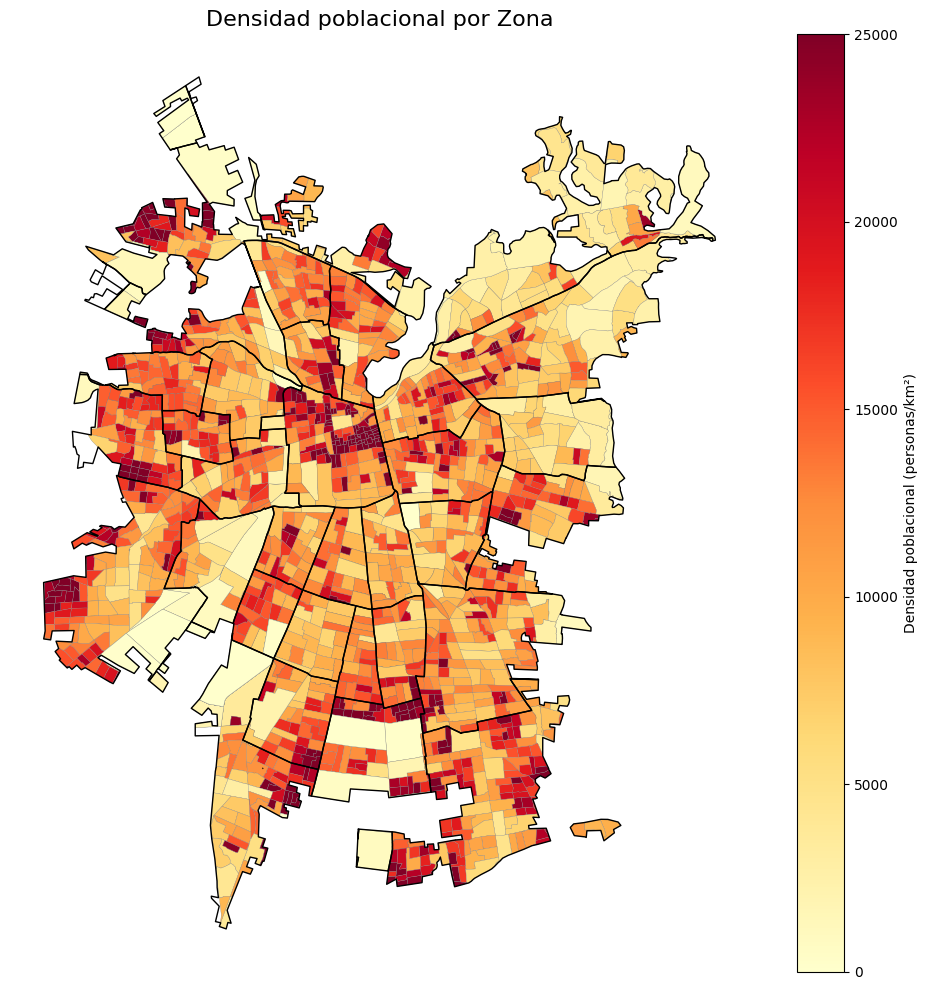

In [138]:
zonas_proj = zonas.to_crs(epsg=32719)
zonas['area_km2'] = zonas_proj.geometry.area / 1e6

zonas['densidad'] = zonas['PERSONAS'] / zonas['area_km2']

fig, ax = plt.subplots(figsize=(10, 10))

vmax = 25000
"""
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(ax=ax, color=f'#{color}', linewidth=5, label=f'Línea {linea}')

"""
zonas.plot(
    column='densidad', ax=ax, cmap='YlOrRd', legend=True, 
    legend_kwds={'label': "Densidad poblacional (personas/km²)"},
    edgecolor='gray', linewidth=0.2, vmax=vmax)

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title('Densidad poblacional por Zona', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

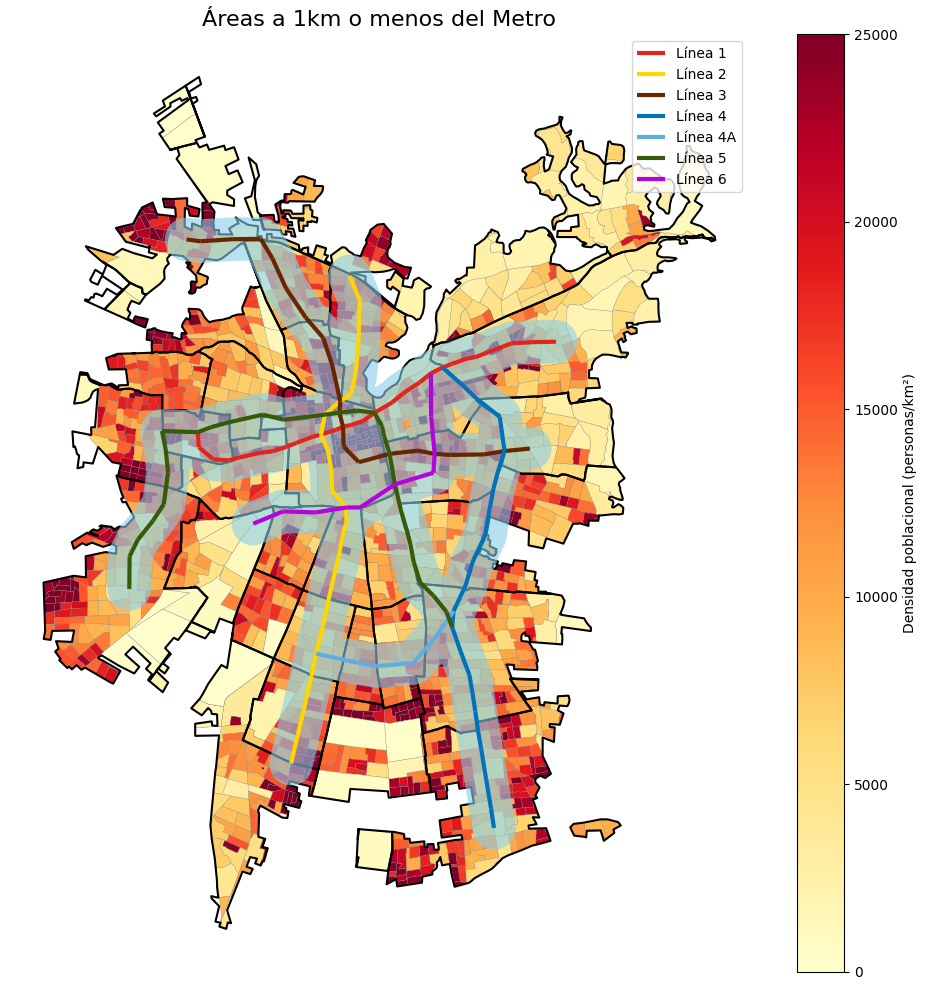

In [139]:
fig, ax = plt.subplots(figsize=(10, 10))

for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(ax=ax, color=f'#{color}', linewidth=3, label=f'Línea {linea}')

zonas.plot(
    column='densidad', ax=ax, cmap='YlOrRd', legend=True, 
    legend_kwds={'label': "Densidad poblacional (personas/km²)"},
    edgecolor='gray', linewidth=0.2, vmax=vmax)

Limite_Comunal.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, label='Límite Comunal')

Metro_proj = Metro.to_crs(epsg=32719)
buffer_1km = Metro_proj.buffer(1000)
buffer_1km_union = buffer_1km.unary_union
buffer_1km_wgs = gpd.GeoSeries([buffer_1km_union], crs="EPSG:32719").to_crs(epsg=4326)

buffer_1km_wgs.plot(ax=ax, color='skyblue', alpha=0.6, label='<= 1km del Metro')

ax.set_title('Áreas a 1km o menos del Metro', fontsize=16)
ax.axis('off')


handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=10)

plt.tight_layout()
plt.show()

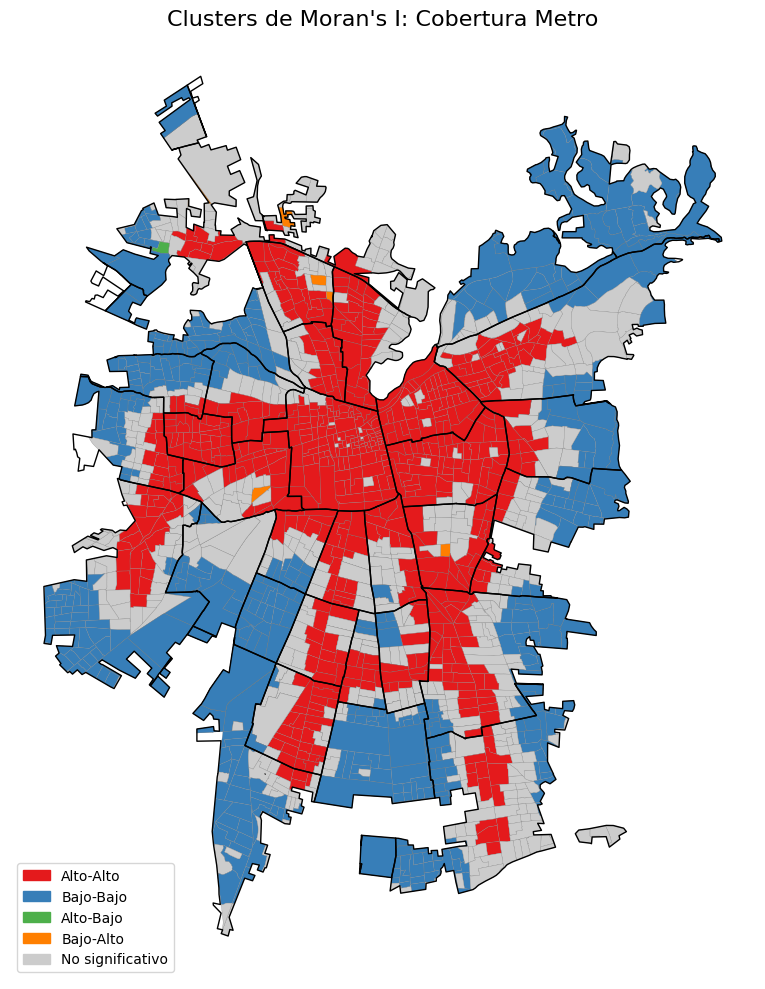

In [140]:
# Crear variable binaria: 1 si la zona está dentro de 1km del metro, 0 si no
zonas['cerca_metro'] = zonas.geometry.intersects(buffer_1km_wgs.iloc[0]).astype(int)

from libpysal.weights import Queen
w_zonas = Queen.from_dataframe(zonas)

from esda.moran import Moran_Local
import matplotlib.colors as mcolors

# Calcular Moran Local para la variable de cobertura del metro
moran_local_metro = Moran_Local(zonas['cerca_metro'], w_zonas)

# Crear columna para los clusters
zonas['cluster_metro'] = 'No significativo'
zonas.loc[(moran_local_metro.q == 1) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Alto-Alto'
zonas.loc[(moran_local_metro.q == 2) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Bajo-Alto'
zonas.loc[(moran_local_metro.q == 3) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Bajo-Bajo'
zonas.loc[(moran_local_metro.q == 4) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Alto-Bajo'

# Definir colores para los clusters
cluster_colors = {
    'Alto-Alto': '#e41a1c',
    'Bajo-Bajo': '#377eb8',
    'Alto-Bajo': '#4daf4a',
    'Bajo-Alto': '#ff7f00',
    'No significativo': '#cccccc'
}

fig, ax = plt.subplots(figsize=(10, 10))
zonas.plot(ax=ax, color=zonas['cluster_metro'].map(cluster_colors), edgecolor='gray', linewidth=0.2)
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Clusters de Moran's I: Cobertura Metro", fontsize=16)
ax.axis('off')

import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend_patches, loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()

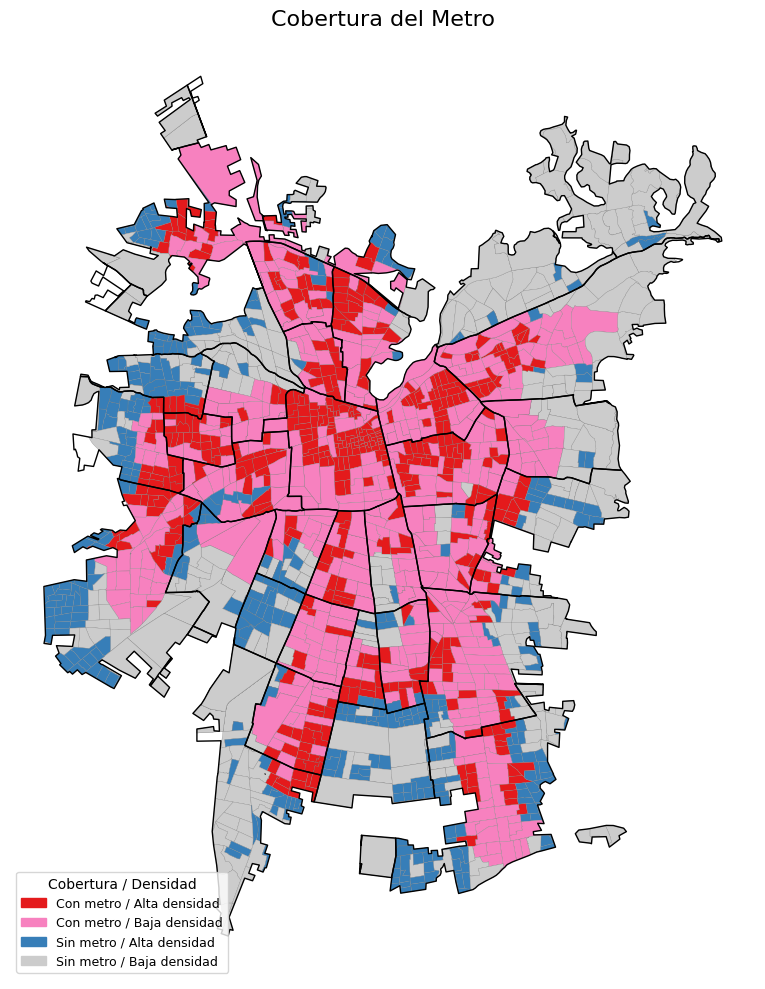

In [141]:
zonas['dens_q'] = pd.qcut(zonas['densidad'], 2, labels=['Baja densidad', 'Alta densidad'])
zonas['metro_q'] = zonas['cerca_metro'].map({0: 'Sin metro', 1: 'Con metro'})
zonas['combo'] = zonas['metro_q'].astype(str) + " / " + zonas['dens_q'].astype(str)

# Paleta de colores combinada
palette_combo = {
    'Con metro / Alta densidad': '#e41a1c',
    'Con metro / Baja densidad': '#f781bf',
    'Sin metro / Alta densidad': '#377eb8',
    'Sin metro / Baja densidad': '#cccccc'
}

fig, ax = plt.subplots(figsize=(10, 10))
zonas.plot(ax=ax, color=zonas['combo'].map(palette_combo), edgecolor='gray', linewidth=0.2)
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Cobertura del Metro", fontsize=16)
ax.axis('off')

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in palette_combo.items()]
ax.legend(handles=legend_patches, loc='lower left', fontsize=9, title='Cobertura / Densidad')

plt.tight_layout()
plt.show()

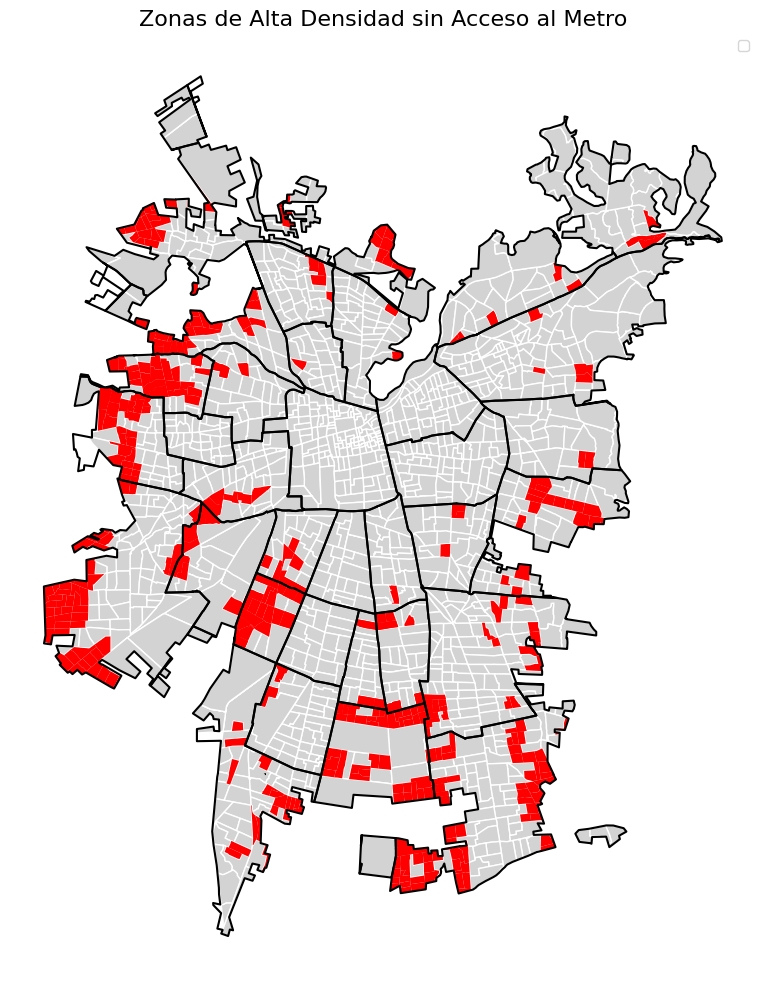

In [142]:
zonas['centroide'] = zonas.geometry.centroid
zonas_criticas = zonas[(zonas['dens_q'] == 'Alta densidad') & (zonas['cerca_metro'] == 0)]

fig, ax = plt.subplots(figsize=(10, 10))
zonas.plot(ax=ax, facecolor='lightgray', edgecolor='white')
zonas_criticas.plot(ax=ax, color='red', markersize=30, label='Alta densidad sin cobertura')
Limite_Comunal.boundary.plot(ax=ax, color='black')

ax.set_title("Zonas de Alta Densidad sin Acceso al Metro", fontsize=16)
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.show()


In [143]:
# Calcular la cantidad total de personas en zonas de alta densidad sin metro
total_personas_zonas_criticas = zonas_criticas['PERSONAS'].sum()
print(f"Cantidad de personas en zonas de alta densidad sin metro: {total_personas_zonas_criticas}")

Cantidad de personas en zonas de alta densidad sin metro: 1923300


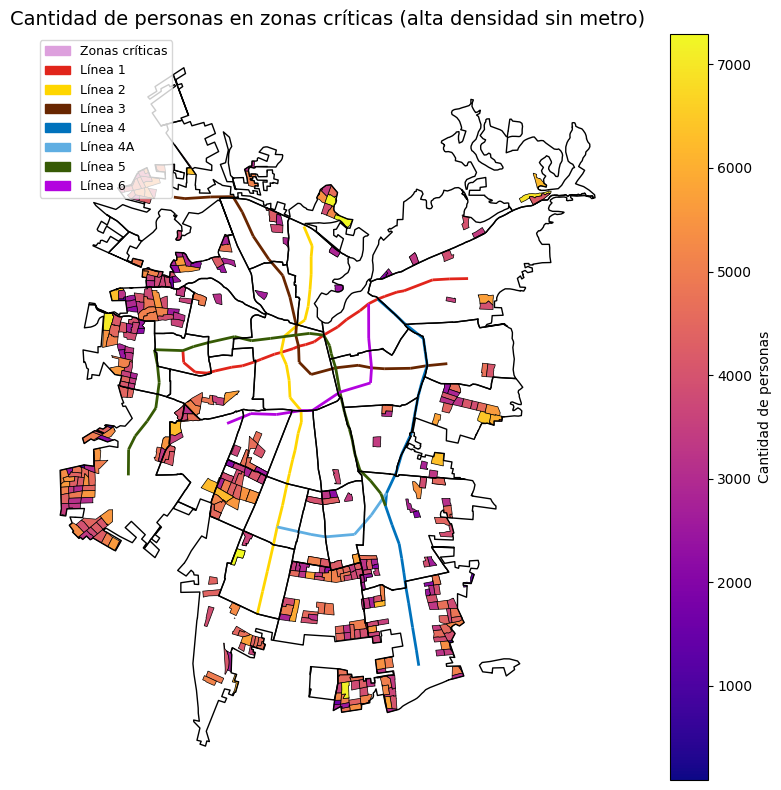

In [144]:
fig, ax = plt.subplots(figsize=(10, 8))

vmin = zonas_criticas['PERSONAS'].min()
vmax = zonas_criticas['PERSONAS'].max()

zonas_criticas.plot(
    column='PERSONAS', ax=ax, cmap='plasma', legend=True,
    legend_kwds={'label': "Cantidad de personas"},
    edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax
)

# Agregar líneas de metro
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax, color=f'#{color}', linewidth=2, label=f'Línea {linea}'
    )

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title('Cantidad de personas en zonas críticas (alta densidad sin metro)', fontsize=14)
ax.axis('off')

# Leyenda personalizada
import matplotlib.patches as mpatches
leyenda = [
    mpatches.Patch(color='plum', label='Zonas críticas'),
]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}'))
ax.legend(handles=leyenda, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

In [207]:
from sklearn.cluster import DBSCAN

# Proyectar a coordenadas en metros (por ejemplo, EPSG:32719)
zonas_criticas_proj = zonas_criticas.to_crs(epsg=32719)
zonas_criticas_proj['x'] = zonas_criticas_proj.geometry.centroid.x
zonas_criticas_proj['y'] = zonas_criticas_proj.geometry.centroid.y

coords = zonas_criticas_proj[['x', 'y']].values

# eps=1000 significa 1 km, ajusta según lo que consideres razonable
db = DBSCAN(eps=1000, min_samples=2).fit(coords)
zonas_criticas['cluster_id'] = db.labels_


In [208]:
# Calcular la suma de personas por cluster
cluster_personas = zonas_criticas.groupby('cluster_id')['PERSONAS'].sum().sort_values(ascending=False)

# Crear un diccionario de mapeo: cluster_id original -> nuevo cluster_id ordenado
cluster_id_map = {old: new for new, old in enumerate(cluster_personas.index)}

# Reasignar los cluster_id en zonas_criticas y zonas_criticas_proj
zonas_criticas['cluster_id'] = zonas_criticas['cluster_id'].map(cluster_id_map)
zonas_criticas_proj['cluster_id'] = zonas_criticas_proj['cluster_id'].map(cluster_id_map)

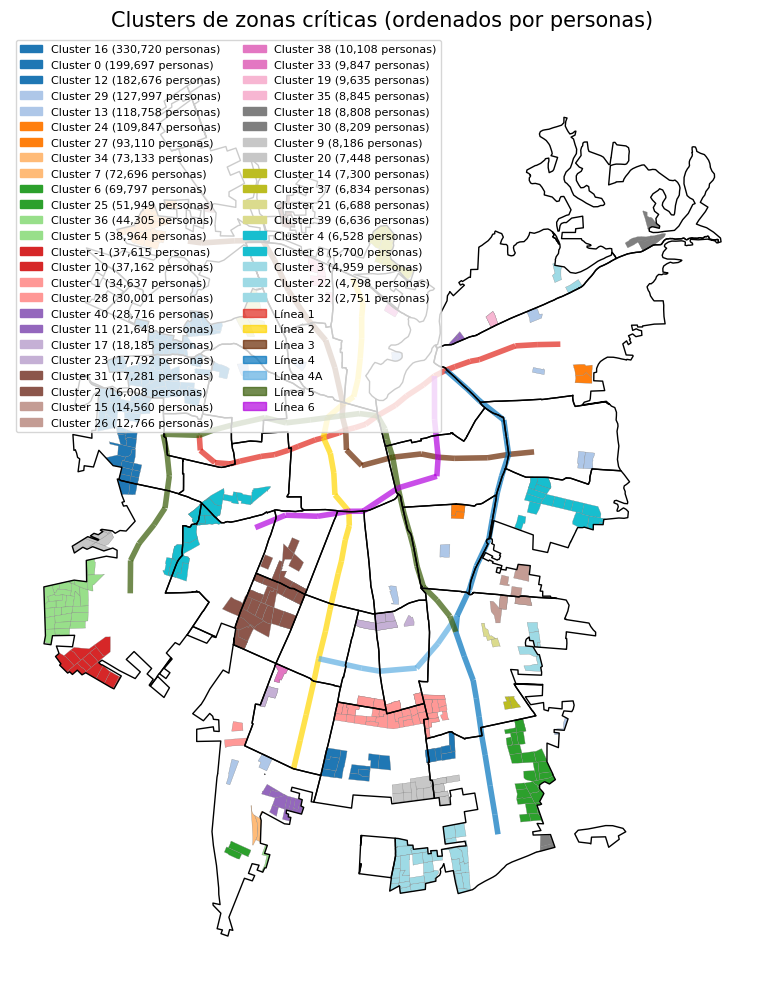

In [209]:
import geemap.foliumap as geemap

# Crear un GeoDataFrame
# Ordenar los cluster_ids según la cantidad de personas
cluster_ids_ordenados = cluster_personas.index.tolist()

# Crear un nuevo colormap ordenado
cmap = cm.get_cmap('tab20', len(cluster_ids_ordenados))
color_dict = {cid: mcolors.to_hex(cmap(i)) for i, cid in enumerate(cluster_ids_ordenados)}

# Asignar color a cada zona crítica según el nuevo orden de cluster_id
zonas_criticas['color_cluster'] = zonas_criticas['cluster_id'].map(color_dict)
zonas_criticas['color_cluster'] = zonas_criticas['color_cluster'].fillna('#cccccc')

fig, ax = plt.subplots(figsize=(10, 10))
zonas_criticas.plot(ax=ax, color=zonas_criticas['color_cluster'], edgecolor='gray', linewidth=0.2)

for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(ax=ax, color=f'#{color}', linewidth=4, alpha=0.7, label=f'Línea {linea}')

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)

ax.set_title('Clusters de zonas críticas (ordenados por personas)', fontsize=15)
ax.axis('off')

# Leyenda de clusters ordenada
leyenda = [mpatches.Patch(color=color_dict[cid], label=f'Cluster {cid} ({cluster_personas[cid]:,} personas)') for cid in cluster_ids_ordenados]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}', alpha=0.7))
ax.legend(handles=leyenda, loc='upper left', fontsize=8, ncol=2)

plt.tight_layout()
plt.show()


In [211]:
import geemap.foliumap as geemap

# Crear un GeoDataFrame solo con las columnas necesarias
zonas_criticas_popup = zonas_criticas[['PERSONAS', 'cluster_id', 'geometry']].copy()
zonas_criticas_popup['cluster_id'] = zonas_criticas_popup['cluster_id'].astype(str)

# Crear el mapa centrado en Santiago
m = geemap.Map(center=[-33.5, -70.65], zoom=11)

# Añadir límites comunales
m.add_gdf(Limite_Comunal, layer_name='Límite Comunal', style={'color': 'black', 'weight': 1, 'fillOpacity': 0})

# Añadir las líneas de metro al mapa
for linea, color in colores_lineas.items():
    m.add_gdf(
        Metro[Metro['linea'] == linea],
        layer_name=f'Línea {linea}',
        style={'color': f'#{color}', 'weight': 4, 'opacity': 0.8}
    )
# Añadir las zonas críticas con popup
m.add_gdf(
    zonas_criticas_popup,
    layer_name='Zonas críticas',
    style_function=lambda x: {
        'fillColor': zonas_criticas.loc[zonas_criticas['PERSONAS'] == x['properties']['PERSONAS']]['color_cluster'].values[0]
        if 'color_cluster' in zonas_criticas.columns else '#cccccc',
        'color': 'gray',
        'weight': 0.5,
        'fillOpacity': 0.7
    }
)
m


In [158]:
# Total de zonas y población
total_zonas = len(zonas)
total_poblacion = zonas['PERSONAS'].sum()

# Zonas cubiertas y no cubiertas
cubiertas = zonas[zonas['cerca_metro'] == 1]
no_cubiertas = zonas[zonas['cerca_metro'] == 0]

n_cubiertas = len(cubiertas)
n_no_cubiertas = len(no_cubiertas)

pob_cubierta = cubiertas['PERSONAS'].sum()
pob_no_cubierta = no_cubiertas['PERSONAS'].sum()

# Porcentaje de población cubierta
porcentaje_cubierta = pob_cubierta / total_poblacion * 100
porcentaje_no_cubierta = pob_no_cubierta / total_poblacion * 100

print(pob_cubierta, f"          ", pob_no_cubierta)
print(porcentaje_cubierta, porcentaje_no_cubierta)

4544914            3336818
57.663899254630834 42.336100745369166


In [160]:
dens_cubiertas = cubiertas['densidad'].mean()
dens_no_cubiertas = no_cubiertas['densidad'].mean()

comunas_excluidas = no_cubiertas.groupby('comuna')['PERSONAS'].sum().sort_values(ascending=False)
top_comunas = comunas_excluidas.head(3)
top_comunas


comuna
PUENTE ALTO    373260
MAIPU          293593
LA PINTANA     252603
Name: PERSONAS, dtype: int64

In [ ]:
from shapely.ops import nearest_points

# Asegurarse de que ambos estén en la misma proyección métrica para medir distancias (por ejemplo, EPSG:32719)
no_cubiertas_proj = no_cubiertas.copy().to_crs(epsg=32719)
gdf_estaciones_proj = gdf_estaciones.to_crs(epsg=32719)

# Obtener los centroides de las zonas no cubiertas
centroides = no_cubiertas_proj.geometry.centroid

# Crear un array de puntos de estaciones de metro
estaciones_points = gdf_estaciones_proj.geometry.unary_union

# Calcular la distancia mínima de cada zona no cubierta a una estación de metro
no_cubiertas_proj['dist_estacion_km'] = centroides.apply(lambda x: x.distance(nearest_points(x, estaciones_points)[1]) / 1000)

# Calcular el promedio
dist_promedio = no_cubiertas_proj['dist_estacion_km'].mean()
print(f"Distancia promedio a la estación de metro más cercana para Zonas no cubiertas: {dist_promedio:.2f} km")


Distancia promedio a la estación de metro más cercana: 2.72 km


In [153]:
zonas['cluster_metro'].value_counts()

cluster_metro
Alto-Alto           913
No significativo    643
Bajo-Bajo           622
Bajo-Alto             6
Alto-Bajo             1
Name: count, dtype: int64

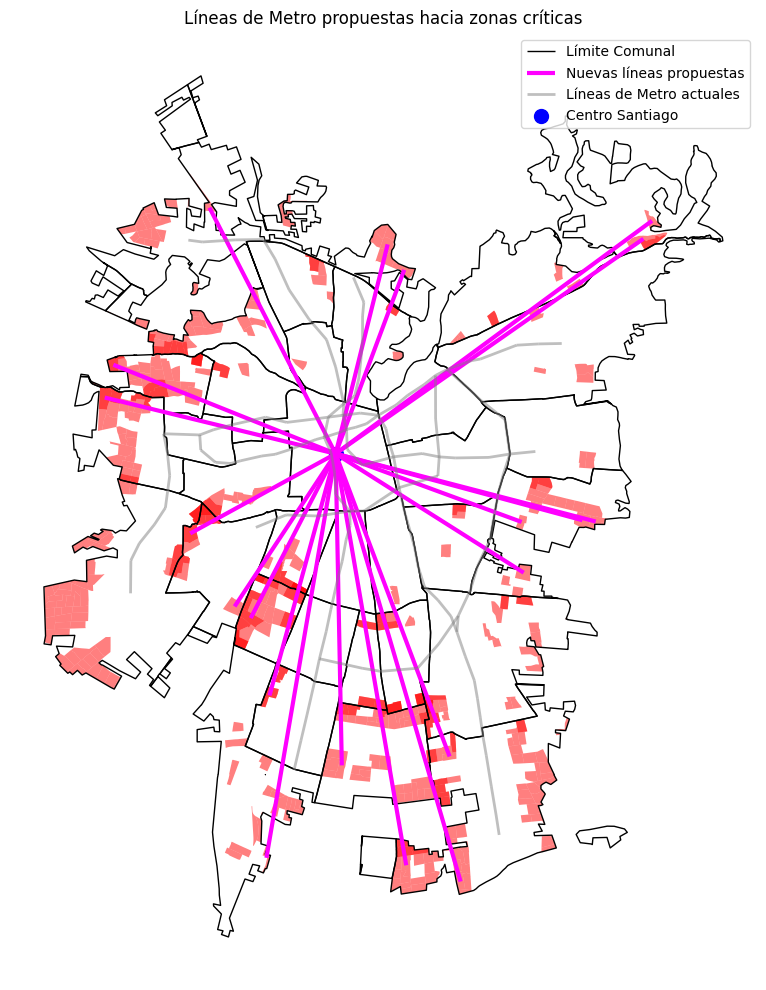

In [166]:
from shapely.geometry import LineString
import geopandas as gpd

# Seleccionar los centroides de las zonas críticas (alta densidad sin metro)
# Ordenar por cantidad de personas descendente y tomar los 5 puntos más críticos
top_criticas = zonas_criticas.sort_values('PERSONAS', ascending=False).drop_duplicates('NZONA').head(20)
centroides_criticos = top_criticas['centroide'].tolist()

# Definir el centro de la ciudad (centroide de Santiago comuna)
centro_santiago = Limite_Comunal[Limite_Comunal['comuna'].str.upper() == 'SANTIAGO'].geometry.centroid.iloc[0]

# Crear líneas desde el centro de Santiago a cada zona crítica
lineas_nuevas = []
for punto in centroides_criticos:
    lineas_nuevas.append(LineString([centro_santiago, punto]))

gdf_lineas_nuevas = gpd.GeoDataFrame(geometry=lineas_nuevas, crs="EPSG:4326")

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1, label='Límite Comunal')
zonas_criticas.plot(ax=ax, color='red', alpha=0.5, label='Zonas críticas')
gdf_lineas_nuevas.plot(ax=ax, color='magenta', linewidth=3, label='Nuevas líneas propuestas')
Metro.plot(ax=ax, color='gray', linewidth=2, alpha=0.5, label='Líneas de Metro actuales')

ax.scatter(*centro_santiago.xy, color='blue', s=100, label='Centro Santiago')
ax.set_title('Líneas de Metro propuestas hacia zonas críticas')
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

## Ejes

In [ ]:
# Filtrar los ejes de jerarquía 1 y 2
Ejes_jerarquia = Ejes[Ejes['hierarchy'].isin([1, 2])]

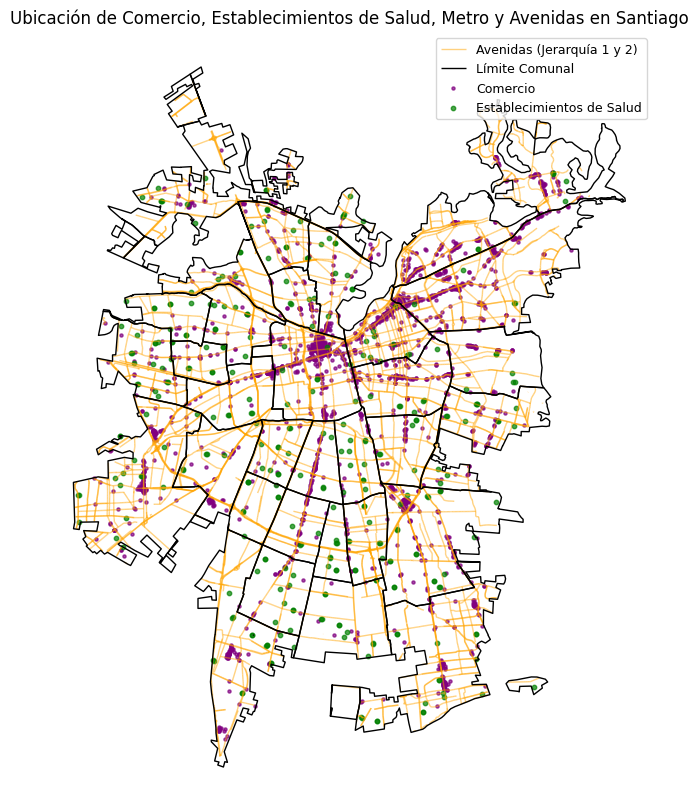

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Avenidas (Ejes jerarquía 1 y 2) al fondo
Ejes_jerarquia.plot(ax=ax, color='orange', linewidth=1, alpha=0.5, label='Avenidas (Jerarquía 1 y 2)')

# 3. Límite comunal
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1, label='Límite Comunal')

# 4. Comercio
Comercio.plot(ax=ax, color='purple', markersize=5, alpha=0.7, label='Comercio')

# 5. Establecimientos de Salud
EstablecimientosSalud.plot(ax=ax, color='green', markersize=10, alpha=0.7, label='Establecimientos de Salud')

ax.set_title('Ubicación de Comercio, Establecimientos de Salud, Metro y Avenidas en Santiago')
ax.axis('off')

# Leyenda personalizada para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.show()

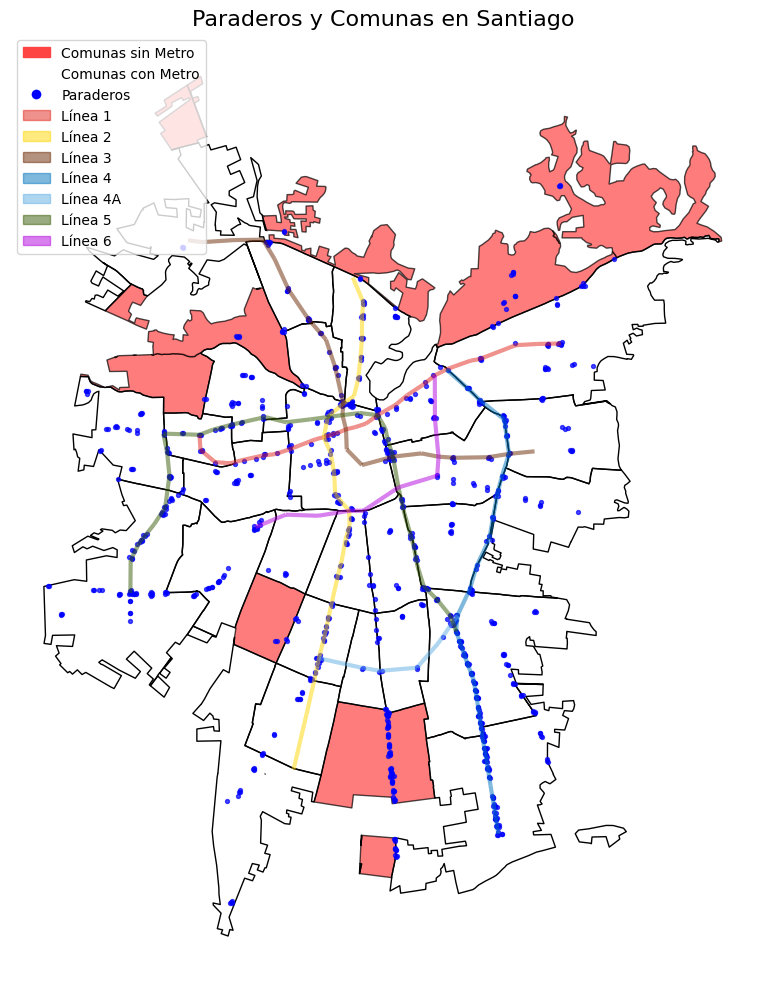

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Comunas sin metro
Limite_Comunal[Limite_Comunal['sin_metro']].plot(
    ax=ax, color='#ff4444', edgecolor='black', linewidth=1, alpha=0.7, label='Comunas sin Metro'
)

# Comunas con metro
Limite_Comunal[~Limite_Comunal['sin_metro']].plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=1, label='Comunas con Metro'
)

# Líneas de metro (con alpha)
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax, color=f'#{color}', linewidth=3, alpha=0.5, label=f'Línea {linea}'
    )

# Paraderos
Paraderos.plot(ax=ax, color='blue', markersize=8, alpha=0.7, label='Paraderos')

ax.set_title('Paraderos y Comunas en Santiago', fontsize=16)
ax.axis('off')

import matplotlib.patches as mpatches
leyenda = [
    mpatches.Patch(color='#ff4444', label='Comunas sin Metro'),
    mpatches.Patch(color='none', edgecolor='black', label='Comunas con Metro'),
    plt.Line2D([0], [0], marker='o', color='w', label='Paraderos', markerfacecolor='blue', markersize=8)
]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}', alpha=0.5))

ax.legend(handles=leyenda, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Área de cada comuna en km²
Limite_Comunal_proj = Limite_Comunal.copy().to_crs(epsg=32719)
Limite_Comunal['area_km2'] = Limite_Comunal_proj.geometry.area / 1e6

# Comercio por comuna
comercio_comuna = gpd.sjoin(Comercio, Limite_Comunal, how='left', predicate='within')
comercio_por_comuna = comercio_comuna.groupby('comuna').size()
Limite_Comunal['densidad_comercio'] = Limite_Comunal['comuna'].map(
    (comercio_por_comuna / Limite_Comunal.set_index('comuna')['area_km2']).to_dict()
)

# Establecimientos de Salud por comuna
salud_comuna = gpd.sjoin(EstablecimientosSalud, Limite_Comunal, how='left', predicate='within')
salud_por_comuna = salud_comuna.groupby('comuna').size()
Limite_Comunal['densidad_salud'] = Limite_Comunal['comuna'].map(
    (salud_por_comuna / Limite_Comunal.set_index('comuna')['area_km2']).to_dict()
)

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Mapa de densidad de comercio
Limite_Comunal.plot(
    column='densidad_comercio', ax=axes[0], cmap='Purples', legend=True,
    legend_kwds={'label': "Densidad de Comercio (cantidad/km²)"}, edgecolor='black'
)

# Mapa de densidad de salud
Limite_Comunal.plot(
    column='densidad_salud', ax=axes[1], cmap='Greens', legend=True,
    legend_kwds={'label': "Densidad de Salud (cantidad/km²)"}, edgecolor='black'
)
axes[1].set_title('Densidad de Establecimientos de Salud por Comuna')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Imagenes Satelitales

In [ ]:
gran_santiago = ee.Geometry.Polygon([
    [[-70.9, -33.8], [-70.9, -33.2], [-70.3, -33.2], [-70.3, -33.8]]
])

def check_images_per_year(start_year, end_year):
    for year in range(start_year, end_year + 1):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        collection = (
            ee.ImageCollection('COPERNICUS/S2_SR')
            .filterDate(start_date, end_date)
            .filterBounds(gran_santiago)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
        )
        count = collection.size().getInfo()
        print(f'Año {year}: {count} imágenes disponibles.')

check_images_per_year(2018, 2025)

Año 2018: 13 imágenes disponibles.
Año 2019: 117 imágenes disponibles.
Año 2020: 125 imágenes disponibles.
Año 2021: 108 imágenes disponibles.
Año 2022: 179 imágenes disponibles.
Año 2023: 157 imágenes disponibles.
Año 2024: 156 imágenes disponibles.
Año 2025: 94 imágenes disponibles.


In [ ]:
gran_santiago = ee.Geometry.Polygon([
    [[-70.9, -33.8], [-70.9, -33.2], [-70.3, -33.2], [-70.3, -33.8]]
])

def mask_s2_sr_clouds(image):
    cloud_prob = image.select('MSK_CLDPRB')
    cloud_mask = cloud_prob.lt(20)
    return image.updateMask(cloud_mask).copyProperties(image, ["system:time_start"])

def get_annual_composite(year):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR')
        .filterDate(start_date, end_date)
        .filterBounds(gran_santiago)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(mask_s2_sr_clouds)
    )
    count = collection.size().getInfo()
    if count == 0:
        print(f"No hay imágenes para el año {year}")
        return None
    median_image = collection.median().clip(gran_santiago)
    return median_image

def urban_index(image):
    return image.normalizedDifference(['B11', 'B8']).rename('NDBI')


ndbi_2018 = urban_index(get_annual_composite(2019))
ndbi_2025 = urban_index(get_annual_composite(2025))

ndbi_diff = ndbi_2025.subtract(ndbi_2018).rename('NDBI_Diff')

Map = geemap.Map(center=[-33.45, -70.65], zoom=10)

diff_vis = {
    'min': -0.5,
    'max': 0.5,
    'palette': [
        '006837',  # verde oscuro (vegetación densa, menos urbano)
        '1a9850',  # verde
        '66bd63',  # verde claro
        '000000',  # amarillo pálido (sin cambio)
        'f46d43',  # naranja
        'd73027',  # rojo (más urbano)
        'a50026'   # rojo oscuro (urbanización intensa)
    ]
}
Map.addLayer(ndbi_diff, diff_vis, 'Cambio NDBI 2019–2023')

Map.add_gdf(Limite_Comunal.boundary, layer_name='Límites comunales', style={'color': 'white', 'weight': 0.8})
 
Map.addLayerControl()
Map

Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Vemos que mayoritariamente, el desarrollo urbano tiene tendencia hacia las afueras de santiago, puede afectar los años de estudio, que son años de estallido social y pandemia, entonces puede ser una idea importante no centrar el transporte en la zona central o ya urbanizada de santiago, si no que expandir el transporte publico, para tener un mejor acceso a comunas como Colina, Lampa, Buin, Peñaflor y notori